<a href="https://colab.research.google.com/github/supsi-dacd-isaac/teaching/blob/main/2021SmartGrids/L03_MPC_for_DSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model predictive control for Demand Side Managment
In this lesson we will go through a practical introduction to model predictive control (MPC) for the control of energy systems and its role in demand side management applications.

We will focus on the control of an heat pump for heating a residential building for which a dynamic electric tariff is in place. Let's start importing the relevant variables for setting up our case study. 


In [14]:
%%capture
!pip install cvxpy
import cvxpy as cvx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
data = pd.read_csv('https://raw.githubusercontent.com/nepslor/teaching/main/2021SmartGrids/data/L04_inputs.csv',  sep=',', index_col=0)
data.index = pd.DatetimeIndex(data.index, freq='H')

In the following cell we define an auxiliary function for visualize groups of columns of a DataFrame to ease the visualization of signals with different scales. 
We divide the dataset $\mathcal{D}$ in two parts: a training set $\mathcal{D}_{tr}$ and a test set $\mathcal{D}_{te}$. We will use the $\mathcal{D}_{tr}$ to train a multivariate forecaster to produce forecasts that will be used by the MPC for optimizing the operations of the heat pump. 

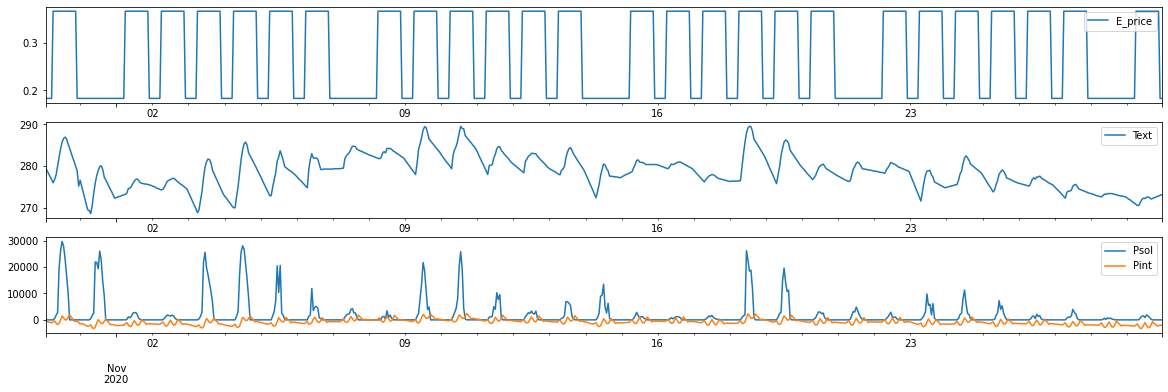

In [15]:
def multiplot(data, *args):
  fig, ax = plt.subplots(len(args), 1, figsize=(20, 2*len(args)))
  for i, p in enumerate(args):
    data[p].plot(ax=ax[i])

data_tr = data.loc[data.index<'2020-10-30']
data_te = data.loc[(data.index<'2020-11-30') & (data.index>'2020-10-30')]
multiplot(data_te, ['E_price'], ['Text'], ['Psol', 'Pint'])


In the following cell we fit a KNN forecaster to predict the 48 hours ahead values for the external temperature $T_{ext}$, the termal contribution of the solar irradiance $P_{sol}$ and additional thermal internal gains $P_{int}$,   using the sklearn implementation [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html).

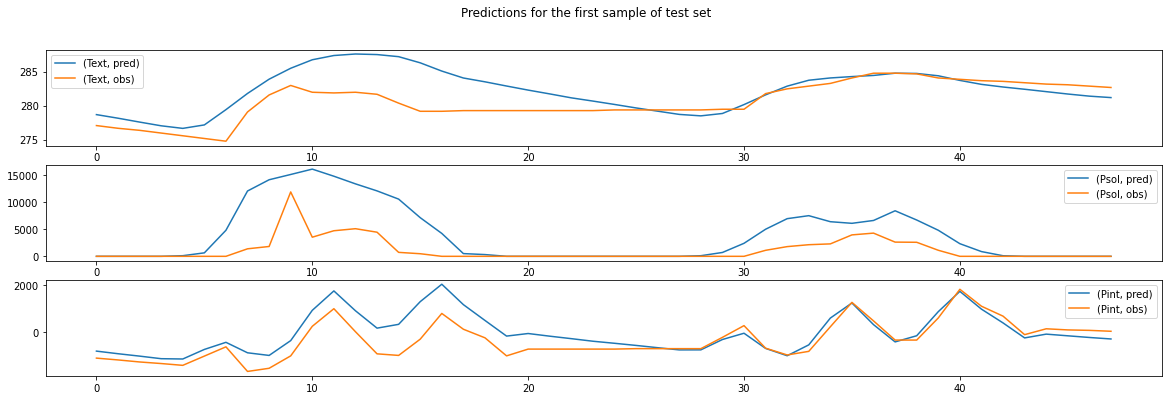

In [16]:
from sklearn.neighbors import KNeighborsRegressor
from itertools import product
  
def add_lags(data, lags, names='all'):
  "adds lagged version of the signal with a given name to the data in the \
  DataFrame. Positive lags: shift forward (future), negative lags: shift\
  backward (past)."
  lagged_signal = pd.concat([data.copy()[names].shift(-l) for l in lags], axis=1)
  lagged_signal.columns = ['{}_lag_{}'.format(p[1], p[0]) for p in 
                           product(lags, names)]
  lagged_dat = pd.concat([data, lagged_signal], axis=1)
  return lagged_dat.loc[~np.any(lagged_dat.isna(), axis=1)]


def fit_forecasters(input_tr, input_te, names):
  forecasters, forecasts, perfect_forecasts, test_obs = {}, {}, {}, {}
  for target in names:
    future_steps = np.arange(1,48)
    past_steps = -np.hstack([np.arange(1,25),np.arange(1,7)*24, np.arange(168-24,169)])
    data_tr = add_lags(input_tr, (future_steps).tolist() + (past_steps).tolist(), names=names)
    data_te = add_lags(input_te, (future_steps).tolist() + (past_steps).tolist(), names=names)

    x_tr, x_te = data_tr[[n for n in data_tr.columns if '-' in n]], data_te[[n for n in data_te.columns if '-' in n]]
    y_tr, y_te = data_tr[[n for n in data_tr.columns if target in n and '-' not in n]], data_te[[n for n in data_te.columns if target in n  and '-' not in n]]

    # normalize data
    tr_mean, te_mean = x_tr.mean(), x_te.mean()
    tr_std, te_std = x_tr.std(), x_te.std()
    x_tr = (x_tr-tr_mean)/tr_std
    x_te = (x_te-te_mean)/te_std

    forecasters[target] = KNeighborsRegressor(weights='distance').fit(x_tr, y_tr.values)
    forecasts[target] = forecasters[target].predict(x_te) 
    perfect_forecasts[target] = y_te.values 
    test_obs[target] = y_te 
  return forecasters, forecasts, perfect_forecasts, test_obs

targets=['Text', 'Psol', 'Pint']
forecasters, forecasts, perfect_forecasts, test_obs = fit_forecasters(data_tr, data_te, targets)
plot_names = list(product(targets, ['pred', 'obs']))
forecast_sample = pd.DataFrame(np.vstack([(forecasts[k][0, :], test_obs[k].values[0, :]) 
for k in targets]).T, columns=plot_names)
multiplot(forecast_sample, plot_names[:2], plot_names[2:4], plot_names[4:])
plt.suptitle('Predictions for the first sample of test set');

The MPC makes use of a model for predicting the future evolution of the system within the control horizon $h$, from which depends the objective function we want to minimize. In our case we want to mantain the building's internal temperature $T_{int} \in \mathbb{R}^h$ stick to a predefine temperature profile $T_{ref} \in \mathbb{R}^h$, while minimizing the energy costs for activating the heat pump serving the heating system. Formally, we want to minimize:
$$ min_{P_{el}} \Vert T_{ref} - T_{int}(P_{el})\Vert_2^2 + \sum_{t=0}^h P_{el,t} p_{e,t} $$  

where $P_{el} \in \mathbb{R}^h$ the decision variable, is the electric power of the heat pump and $p_{e,t}$ is the electricity price at time $t$. 

As a first approximation, the internal temperature depends on the thermal power of the heating system, solar gains and heat dissipated by internal electric devices. We can write a reasonable dynamic linear system for the evolution of the temperature writing the energy conservation equation for the building:

$$ C_{th} \frac{\partial T_{int}}{\partial t} = \frac{T_{ext} - T_{int}}{R_{th}} + P_h + P_{sol} + P_{int}$$
where $P_h$ is the thermal power from the heat pump, $P_{sol}$ is the heating power due to solar irradiance, and $P_{int}$ are other internal gains from electric appliances and people in the building. The above formula can be interpreted as an equivalent RC circuit, by applying the following analogies following analogies:

| Quantity    | Electrical |  Thermal|
| ----------- | -----------    | ----------- | 
| Potential   | $U$ [$V$]      | $T$ [$K$]   |
| Flux        | $I$ [$A$]      | $P$ [$W$]   |
| Resistance  | $R$ [$\Omega$] | $R_{th}$ [$K/W$]|
| Capacity    | $C$ [$F$]      | $C_{th}$ [J/K]|

The following figure illustrates the one state RC equivalent for our building. Usually, a multi-state system identification is performed. The number of identifiable states greatly depends on the number of temperature and power sensors available and on the signal to noise ratio of the available measurements. Despite its simplicity, the one state RC is well suited to illustrate the methodology of controlling a dynamic system for DSM applications.
The external temperature is modeled with a voltage source, while the injected thermal powers with a current source.

<center><img src="https://github.com/nepslor/teaching/raw/main/2021SmartGrids/figs/RC_circuit.png" width="600"></center>

The above equation can be rearranged in the canonical state-space form:
$$\frac{\partial T_{int}}{\partial t}=A T_{int} +B u$$

where $A = \frac{-1}{R_{th}C_{th}}$, $B = [\frac{1}{R_{th}C_{th}}, \frac{1}{C_{th}}]$ and $u = [T_{ext}, P_h+P_{int}+P_{sol}]$ is the vector of control signals and external disturbances, here the external tempearture, the heat from the heating system, the solar and internal gains.

We can pass from the continuos time state-space representation to the discrete one by applying the following transform:
$$
\begin{array}{l}
A_{d}=e^{A d t} \\
B_{d}=A^{-1}\left(A_{d}-I\right) B
\end{array}
$$

In the following cell we will define the C and U (1/R) parameters for the considered building and retrieve $A_d$ and $B_d$.


In [17]:
dt = 3600             # Sampling time [s]
C = 4.83e7            # C - heat capacity [J/K]
U = 652.8             # External conductivity [W/K]

Ac = np.atleast_2d(np.array(-U/C))
Bc = np.atleast_2d(np.array([U/C, 1/C]))

# Exact discretization
Ad = np.exp(dt*Ac)        
Bd = np.linalg.inv(Ac)@(Ad - 1)@Bc
print('Ad: {}\nBd: {}'.format(np.round(Ad, 5), np.round(Bd, 5)))

Ad: [[0.95251]]
Bd: [[4.749e-02 7.000e-05]]


We can pass from the electric power of the heat pump $P_{el}$ to the thermal one $P_{th}$ using the coefficient of performance, which can be in first approximation described as a function of the evaporation and condensation temperatures of the heat pump:
$$P_h = COP(T_{ev}, T_{cond}) P_{el}$$
In the following cell we formulate the approximated COP expression and plot it as a function of T_{ev} T_{cond}. As further approximation we replace $T_{ev}$ with the external temperature $T_{ext}$. 

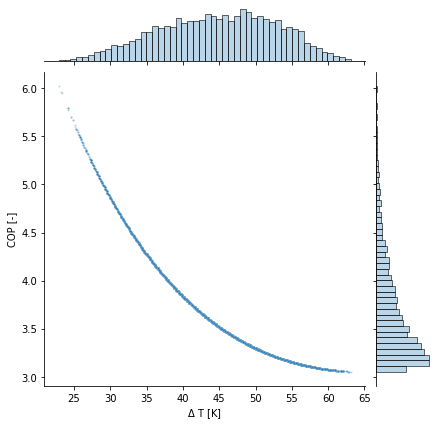

In [18]:
h = 48                 # control horizon [time steps]

N = len(data_te)-h     # maximum available timestep
P_hp_nom = 4.088       # nominal power of the heat pump [kW]
T_dist = 273.15 + 55   # temperature of water in the heating system [K]

# Let's define an approximate function of the HP coefficient of performance as 
# a function of temeprature difference between heating system's water 
# temperature and ambient temperature
cop = lambda t_dist, t_ext: 13.39*np.exp(-0.047*(t_dist-t_ext))+1.109*np.exp(0.012*(t_dist-t_ext))
COP = cop(T_dist, data['Text'])

# plot the COP
spl = sb.jointplot(x=T_dist-data['Text'], y=COP.values, s=4,alpha=0.3, marginal_kws=dict(bins=50, alpha=0.3))
spl.ax_joint.set_xlabel('$\Delta$ T [K]')
spl.ax_joint.set_ylabel('COP [-]');

# MPC implementation through cvxpy
At each time step, the MPC solves an optimization problem casted on the whole control horizon $h$, in this case 48 hours. We use the modeling language for convex programming [CVXPY](https://www.cvxpy.org/) to define the base optimization problem solved at each step. 

In [19]:

k_eco = 10  # relative importance of the economic objective
 
# Setpoint temperature of the heating system: daytime=20°C, nightime=18°C
t_int_ref = (np.kron(np.ones(int((N+h+1)/24)), np.hstack([18]*6 + 
  [20]*16 + [18]*2))+273.15)[:data_te.shape[0]]

# variables - the optimization problem will search for the best values of these
# quantities

t_int = cvx.Variable((h+1, 1), name='internal temperature')
p_heat_hp = cvx.Variable((h, 1), name='heating power HP')
p_el_hp = cvx.Variable((h, 1), name='electric power HP')


# parameters - these can be set at each instance of the problems
p_gains = cvx.Parameter((h, 1), name='forecasted internal gains')
t_ext = cvx.Parameter((h, 1), name='forecasted external temperature')
cop_hp = cvx.Parameter((h, 1), name='forecasted COP of the HP')
e_price = cvx.Parameter((h, 1), name='electricity price')
t_int_ref_h = cvx.Parameter((h, 1), name='minimum internal temperature')
t_init = cvx.Parameter(1)

# initial internal house temperature
constraints = [t_int[0] == t_init]  

# heat dynamics of the building
constraints.append(t_int[1:] == Ad @ t_int[0:-1] + t_ext*Bd[0,0] 
                   + (p_gains + p_heat_hp*1e3)* Bd[0,1])

# heating power constraints of the heat pump
constraints.append(0 <= p_heat_hp) 
constraints.append(p_heat_hp == cvx.multiply(cop_hp, p_el_hp))

# electric power constraints of the heat pump
constraints.append(0 <= p_el_hp) 
constraints.append(p_el_hp <= P_hp_nom)

# set objective function to minimize
objective = cvx.sum((t_int_ref_h-t_int[0:-1])**2) \
            + k_eco * cvx.sum(cvx.multiply(e_price, p_el_hp))
problem = cvx.Problem(cvx.Minimize(objective), constraints=constraints)

We can now simulate 500 steps of the MPC strategy. We will at first use perfect forecasts for the relevant quantities to have a better grasp on what is going on. 

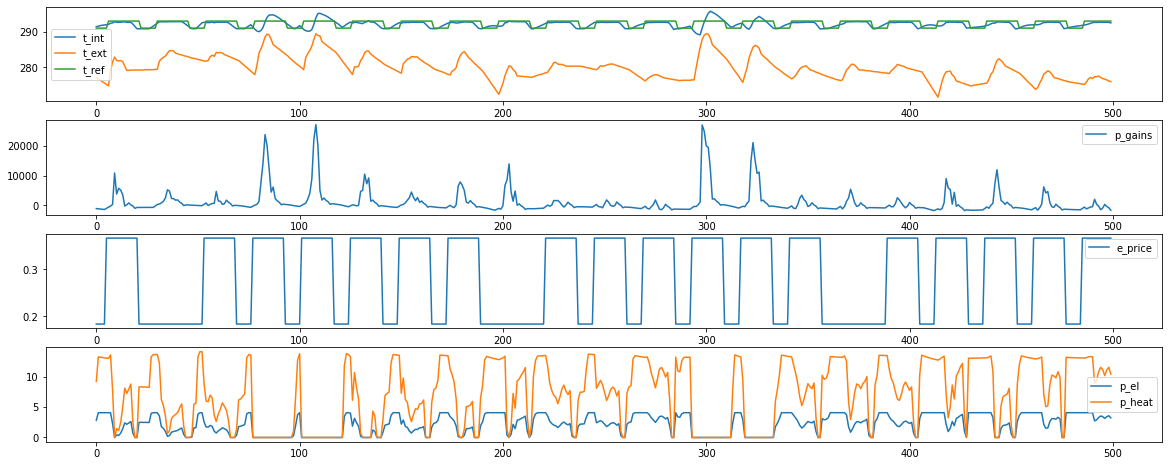

In [20]:
# initial temperature
t_int_obs = np.atleast_1d(t_int_ref[0]+0.5)

mpc_forecats = perfect_forecasts
n_steps = 500
history = pd.DataFrame(columns=['t_int', 't_ext', 't_ref', 'p_gains', 'e_price', 'p_el', 'p_heat'], index=np.arange(n_steps))

for i in range(n_steps):
  p_gains.value = np.vstack([mpc_forecats[k][i, :] for k in ['Pint', 'Psol']]).T.sum(axis=1, keepdims=True)
  t_ext.value = mpc_forecats['Text'][[i], :].T
  cop_hp.value = cop(T_dist, t_ext.value)
  e_price.value = data_te['E_price'].iloc[i:i+h].values.reshape(-1,1)
  t_int_ref_h.value = t_int_ref[i:i+h].reshape(-1,1)
  t_init.value = np.atleast_1d(t_int_obs)

  problem.solve()

  # obtain realized temperature 
  t_ext_obs = test_obs['Text'].iloc[i, 0]
  p_gains_obs = (test_obs['Psol'].iloc[i, 0] + test_obs['Pint'].iloc[i, 0])
  
  t_int_obs = Ad @ t_int_obs + t_ext_obs * Bd[0,0] + (p_gains_obs + p_heat_hp.value[0]*1e3)*Bd[0,1]
  history.iloc[i, :] = np.hstack([t_int_obs, t_ext_obs, t_int_ref_h.value[0], p_gains_obs, e_price.value[0], p_el_hp.value[0], p_heat_hp.value[0]])

multiplot(history, ['t_int', 't_ext', 't_ref'], ['p_gains'], ['e_price'], ['p_el', 'p_heat'])

The MPC is trying to find a balance between getting stick to the reference temperature profile and opearting the heat pump when the electricity price is low. Now we can try to plug in the real forecasts we have previously obtained with the KNN regressor for the external temperature, the solar and the internal gains, and compare the results with ones of the MPC with perfect knowledge of the future. 

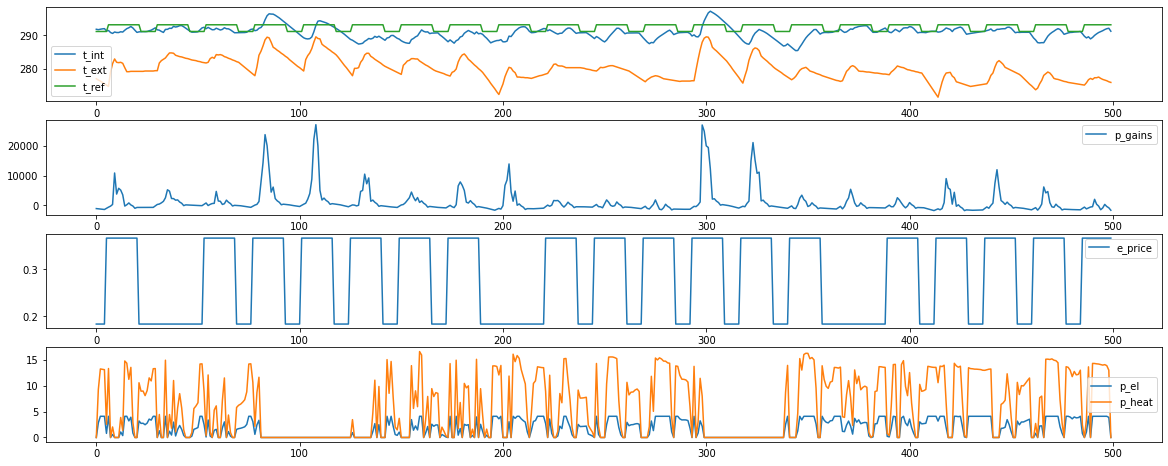

In [21]:
mpc_forecats = forecasts
n_steps = 500
history = pd.DataFrame(columns=['t_int', 't_ext', 't_ref', 'p_gains', 'e_price', 'p_el', 'p_heat'], index=np.arange(n_steps))
for i in range(n_steps):
  p_gains.value = np.vstack([mpc_forecats[k][i, :] for k in ['Pint', 'Psol']]).T.sum(axis=1, keepdims=True)
  t_ext.value = mpc_forecats['Text'][[i], :].T
  cop_hp.value = cop(T_dist, t_ext.value)
  e_price.value = data_te['E_price'].iloc[i:i+h].values.reshape(-1,1)
  t_int_ref_h.value = t_int_ref[i:i+h].reshape(-1,1)
  t_init.value = np.atleast_1d(t_int_obs)

  problem.solve()

  # obtain realized temperature 
  t_ext_obs = test_obs['Text'].iloc[i, 0]
  p_gains_obs = (test_obs['Psol'].iloc[i, 0] + test_obs['Pint'].iloc[i, 0])
  
  t_int_obs = Ad @ t_int_obs + t_ext_obs * Bd[0,0] + (p_gains_obs + p_heat_hp.value[0]*1e3)*Bd[0,1]
  history.iloc[i, :] = np.hstack([t_int_obs, t_ext_obs, t_int_ref_h.value[0], p_gains_obs, e_price.value[0], p_el_hp.value[0], p_heat_hp.value[0]])

multiplot(history, ['t_int', 't_ext', 't_ref'], ['p_gains'], ['e_price'], ['p_el', 'p_heat'])